# Tutorial 2: resolution of Poisson problem and usage of extra-features

### The problem definition

This tutorial presents how to solve with Physics-Informed Neural Networks a 2D Poisson problem with Dirichlet boundary conditions.

The problem is written as:
\begin{equation}
\begin{cases}
\Delta u = \sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square.

First of all, some useful imports.

In [1]:
import torch
from torch.nn import ReLU, Tanh, Softplus

from pina.problem import SpatialProblem
from pina.operators import nabla
from pina.model import FeedForward
from pina import Condition, Span, PINN, LabelTensor, Plotter

Now, the Poisson problem is written in PINA code as a class. The equations are written as *conditions* that should be satisfied in the corresponding domains. *truth_solution*
is the exact solution which will be compared with the predicted one.

In [2]:
class Poisson(SpatialProblem):
    output_variables = ['u']
    spatial_domain = Span({'x': [0, 1], 'y': [0, 1]})

    def laplace_equation(input_, output_):
        force_term = (torch.sin(input_.extract(['x'])*torch.pi) *
                      torch.sin(input_.extract(['y'])*torch.pi))
        nabla_u = nabla(output_, input_, components=['u'], d=['x', 'y'])
        return nabla_u - force_term

    def nil_dirichlet(input_, output_):
        value = 0.0
        return output_.extract(['u']) - value

    conditions = {
        'gamma1': Condition(Span({'x': [0, 1], 'y':  1}), nil_dirichlet),
        'gamma2': Condition(Span({'x': [0, 1], 'y': 0}), nil_dirichlet),
        'gamma3': Condition(Span({'x':  1, 'y': [0, 1]}), nil_dirichlet),
        'gamma4': Condition(Span({'x': 0, 'y': [0, 1]}), nil_dirichlet),
        'D': Condition(Span({'x': [0, 1], 'y': [0, 1]}), laplace_equation),
    }

    def poisson_sol(self, pts):
        return -(
            torch.sin(pts.extract(['x'])*torch.pi)*
            torch.sin(pts.extract(['y'])*torch.pi)
        )/(2*torch.pi**2)
    
    truth_solution = poisson_sol

### The problem solution 

After the problem, the feed-forward neural network is defined, through the class `FeedForward`. This neural network takes as input the coordinates (in this case $x$ and $y$) and provides the unkwown field of the Poisson problem. The residual of the equations are evaluated at several sampling points (which the user can manipulate using the method `span_pts`) and the loss minimized by the neural network is the sum of the residuals.

In this tutorial, the neural network is composed by two hidden layers of 10 neurons each, and it is trained for 1000 epochs with a learning rate of 0.006. These parameters can be modified as desired.
The output of the cell below is the final loss of the training phase of the PINN.
We highlight that the generation of the sampling points and the train is here encapsulated within the function `generate_samples_and_train`, but only for saving some lines of code in the next cells; that function is not mandatory in the **PINA** framework. 

In [3]:
def generate_samples_and_train(model, problem):
    pinn = PINN(problem, model, lr=0.006, regularizer=1e-8)
    pinn.span_pts(20, 'grid', locations=['D'])
    pinn.span_pts(20, 'grid', locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    pinn.train(1000, 100)
    return pinn

problem = Poisson()
model = FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_variables=problem.output_variables,
    input_variables=problem.input_variables
)

pinn = generate_samples_and_train(model, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 4.821361e-01 7.271265e-02 5.749976e-02 7.188050e-02 5.793815e-02 2.221050e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 3.231621e-01 2.852444e-02 1.981721e-02 2.768876e-02 2.037603e-02 2.267557e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 1.015092e-01 5.198789e-04 2.826267e-03 3.158009e-03 2.300746e-03 9.270430e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 8.891604e-02 4.115215e-04 5.373723e-04 5.063288e-04 5.177262e-04 8.694309e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 8.620024e-02 3.734426e-04 4.014817e-04 3.966301e-04 4.261272e-04 8.460256e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

The neural network of course can be saved in a file. In such a way, we can store it after the train, and load it just to infer the field. Here we don't store the model, but for demonstrative purposes  we put in the next cell the commented line of code.

In [4]:
# pinn.save_state('pina.poisson')

Now the *Plotter* class is used to plot the results.
The solution predicted by the neural network is plotted on the left, the exact one is represented at the center and on the right the error between the exact and the predicted solutions is showed. 

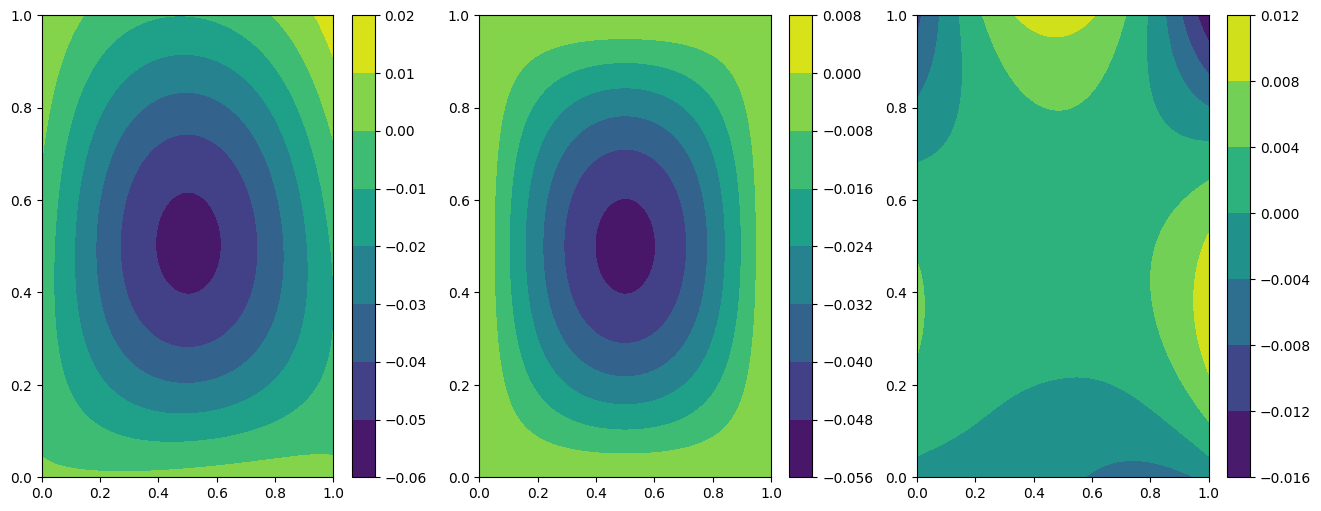

In [5]:
plotter = Plotter()
plotter.plot(pinn)

### The problem solution with extra-features

Now, the same problem is solved in a different way.
A new neural network is now defined, with an additional input variable, named extra-feature, which coincides with the forcing term in the Laplace equation. 
The set of input variables to the neural network is:

\begin{equation}
[x, y, k(x, y)], \text{ with } k(x, y)=\sin{(\pi x)}\sin{(\pi y)},
\end{equation}

where $x$ and $y$ are the spatial coordinates and $k(x, y)$ is the added feature. 

This feature is initialized in the class `SinSin`, which needs to be inherited by the `torch.nn.Module` class and to have the `forward` method. After declaring such feature, we can just incorporate in the `FeedForward` class thanks to the `extra_features` argument.
**NB**: `extra_features` always needs a `list` as input, you you have one feature just encapsulated it in a class, as in the next cell.

Finally, we perform the same training as before: the problem is `Poisson`, the network is composed by the same number of neurons and optimizer parameters are equal to previous test, the only change is the new extra feature.

In [6]:
class SinSin(torch.nn.Module):
    """Feature: sin(x)*sin(y)"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        t = (torch.sin(x.extract(['x'])*torch.pi) *
             torch.sin(x.extract(['y'])*torch.pi))
        return LabelTensor(t, ['sin(x)sin(y)'])

model_feat = FeedForward(
        layers=[10, 10],
        output_variables=problem.output_variables,
        input_variables=problem.input_variables,
        func=Softplus,
        extra_features=[SinSin()]
    )

pinn_feat = generate_samples_and_train(model_feat, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 8.334048e-02 1.480584e-02 1.326940e-02 1.505190e-02 1.282023e-02 2.739312e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 2.369340e-02 1.785535e-03 1.441936e-03 1.978278e-03 1.193302e-03 1.729435e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.190661e-05 5.259407e-06 2.207154e-06 1.740728e-06 1.258537e-06 3.144078e-05 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 2.964181e-06 3.873027e-08 3.952280e-08 6.926503e-08 4.859637e-08 2.768067e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 2.477657e-06 3.019578e-08 3.888974e-08 5.290904e-08 4.751930e-08 2.308143e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

The predicted and exact solutions and the error between them are represented below.
We can easily note that now our network, having almost the same condition as before, is able to reach an additional order of magnitude in accuracy.

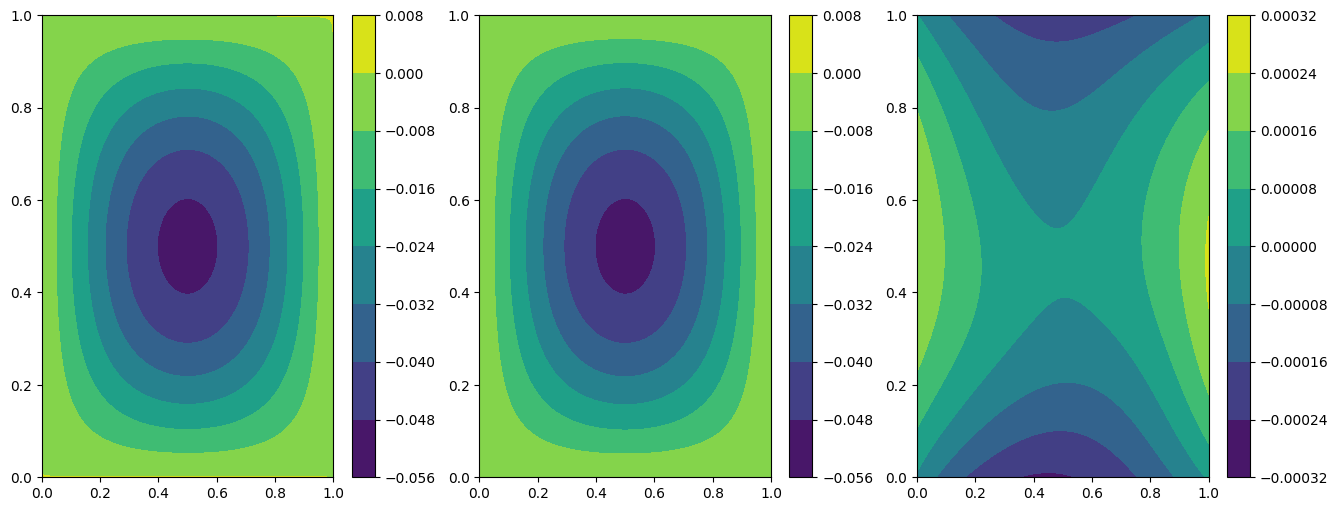

In [7]:
plotter.plot(pinn_feat)

### The problem solution with learnable extra-features

We can still do better!

Another way to exploit the  extra features is the addition of learnable parameter inside them.
In this way, the added parameters are learned during the training phase of the neural network. In this case, we use:

\begin{equation}
k(x, \mathbf{y}) = \beta \sin{(\alpha x)} \sin{(\alpha y)},
\end{equation}

where $\alpha$ and $\beta$ are the abovementioned parameters.
Their implementation is quite trivial: by using the class `torch.nn.Parameter` we cam define all the learnable parameters we need, and they are managed by `autograd` module!

In [8]:
class SinSinAB(torch.nn.Module):
    """ """
    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.tensor([1.0]))


    def forward(self, x):
        t =  (
            self.beta*torch.sin(self.alpha*x.extract(['x'])*torch.pi)*
                      torch.sin(self.alpha*x.extract(['y'])*torch.pi)
        )
        return LabelTensor(t, ['b*sin(a*x)sin(a*y)'])


model_learn = FeedForward(
    layers=[10, 10],
    output_variables=problem.output_variables,
    input_variables=problem.input_variables,
    extra_features=[SinSinAB()]
)

pinn_learn = generate_samples_and_train(model_learn, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 3.918677e-01 2.501913e-02 1.278682e-02 1.963722e-02 1.756839e-02 3.168561e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 1.345929e-01 1.696471e-02 9.475741e-03 1.432935e-02 1.169397e-02 8.212914e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.500092e-04 1.441140e-05 9.839978e-06 2.283052e-05 4.087769e-06 3.988396e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 2.102947e-04 1.462936e-05 2.168394e-06 4.655578e-06 4.340448e-07 1.884074e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 1.371512e-04 1.072066e-05 1.284032e-06 2.897264e-06 1.126986e-06 1.211222e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

Umh, the final loss is not appreciabily better than previous model (with static extra features), despite the usage of learnable parameters. This is mainly due to the over-parametrization of the network: there are many parameter to optimize during the training, and the model in unable to understand automatically that only the parameters of the extra feature (and not the weights/bias of the FFN) should be tuned in order to fit our problem. A longer training can be helpful, but in this case the faster way to reach machine precision for solving the Poisson problem is removing all the hidden layers in the `FeedForward`, keeping only the $\alpha$ and $\beta$ parameters of the extra feature.

In [9]:
model_learn = FeedForward(
    layers=[],
    output_variables=problem.output_variables,
    input_variables=problem.input_variables,
    extra_features=[SinSinAB()]
)

pinn_learn = generate_samples_and_train(model_learn, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 1.974945e+00 2.002993e-03 7.012323e-02 2.755559e-02 1.584911e-02 1.859414e+00 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 1.761779e+00 3.188374e-03 6.539153e-02 2.452723e-02 1.474262e-02 1.653930e+00 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.036187e-03 1.676370e-05 2.384196e-05 1.675912e-05 2.528631e-05 3.953536e-03 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 3.638973e-06 9.148435e-09 5.011525e-09 8.995231e-09 5.055353e-09 3.610763e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 7.258809e-11 2.040413e-13 1.323202e-13 1.966580e-13 1.385408e-13 7.191653e-11 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

In such a way, the model is able to reach a very high accuracy!
Of course, this is a toy problem for understanding the usage of extra features: similar precision could be obtained if the extra features are very similar to the true solution. The analyzed Poisson problem shows a forcing term very close to the solution, resulting in a perfect problem to address with such an approach.

We conclude here by showing the graphical comparison of the unknown field and the loss trend for all the test cases presented here: the standard PINN, PINN with extra features, and PINN with learnable extra features.

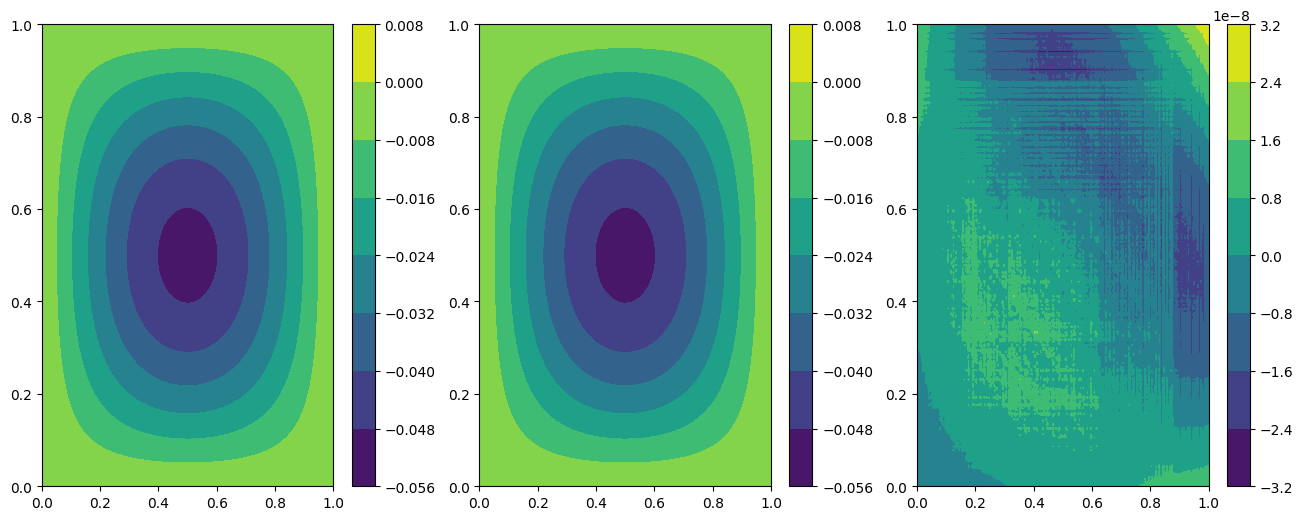

In [10]:
plotter.plot(pinn_learn)

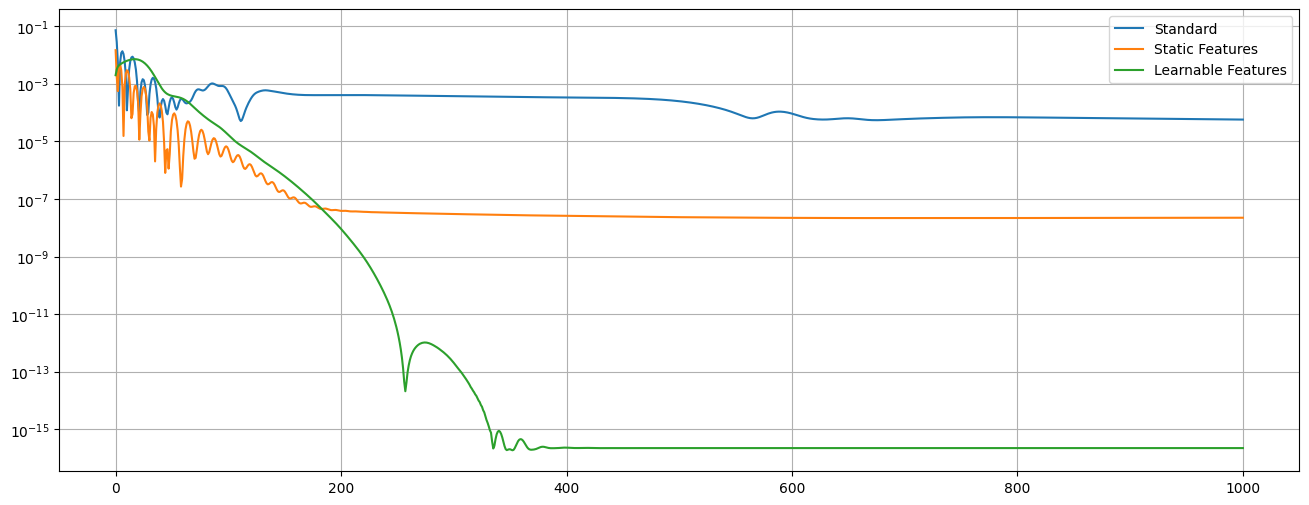

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plotter.plot_loss(pinn, label='Standard')
plotter.plot_loss(pinn_feat, label='Static Features')
plotter.plot_loss(pinn_learn, label='Learnable Features')

plt.grid()
plt.legend()
plt.show()